In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import math

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss

from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import matplotlib as mpl

import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Input
from keras.optimizers import Adam
from keras.models import Model

dataset = pd.read_csv('../data/Dataset_refined/complete.csv', sep=',')
dataset = dataset.drop(['velocity'], axis=1)
X = dataset.iloc[:,0:-1].values
y = dataset.iloc[:,-1].values

os.environ['CUDA_VISIBLE_DEVICES'] = "0"

Using TensorFlow backend.


In [2]:
right_turns = y[np.where(y > 0.1)]
left_turns = y[np.where(y < -0.1)]
print("Number of right turns: ", right_turns.shape[0])
print("max: ", np.amax(y))
print("median: ", np.median(y))
print("min: ", np.amin(y))
print("Number of left turns: ", left_turns.shape[0])

Number of right turns:  2601
max:  0.4189
median:  -0.037106018513441086
min:  -0.4189
Number of left turns:  2666


In [3]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [44]:
#Plot data
angle_inc = math.radians(0.25)
angle_start = -math.radians(45)

SEQ_IDX= 2084
data_plot= x_train[SEQ_IDX]

x = []
y = []

for i in range(len(data_plot)):
    angle = angle_start + i * angle_inc
    x.append(data_plot[i]*math.cos(angle))
    y.append(data_plot[i]*math.sin(angle))

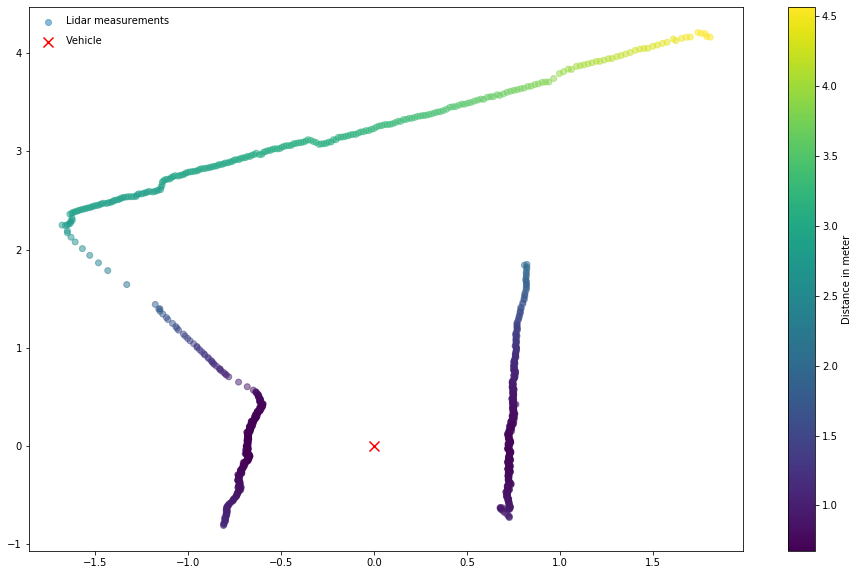

Output:  -0.06096842139959335


In [45]:
norm = mpl.colors.Normalize(vmin=np.amin(data_plot), vmax=np.amax(data_plot))

fig = plt.figure(figsize=(16,10))
plt.scatter(x,y, c=(data_plot), cmap='viridis', marker='o', alpha=0.5, label='Lidar measurements')
plt.scatter(x=0, y=0,s=100, c='r', marker="x", label='Vehicle')
plt.axis(aspect='equal')

plt.colorbar(mpl.cm.ScalarMappable(norm=norm), label='Distance in meter')
plt.legend(labelspacing=1,frameon=False)
plt.show()
print("Output: ", y_train[SEQ_IDX])

In [28]:
#Normalization
from sklearn.preprocessing import MinMaxScaler
#from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
scaler.fit(X)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [34]:
#MLP Grid search model
mlp = MLPRegressor(max_iter=200)
parameter_space = {
    'hidden_layer_sizes': [(80,100,80)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [0.0001],
    'learning_rate': ['constant'],
}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=5)
clf.fit(x_train, y_train)

# Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 100, 80), 'learning_rate': 'constant', 'solver': 'adam'}
0.764 (+/-0.075) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (80, 100, 80), 'learning_rate': 'constant', 'solver': 'adam'}
0.702 (+/-0.198) for {'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (5, 10, 5), 'learning_rate': 'constant', 'solver': 'adam'}


In [5]:
#Train MLP from Grid Search
mlp_best = MLPRegressor(
    hidden_layer_sizes=(80,100,80),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    learning_rate='constant',
    max_iter=200
)
mlp_best.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
             beta_2=0.999, early_stopping=False, epsilon=1e-08,
             hidden_layer_sizes=(80, 100, 80), learning_rate='constant',
             learning_rate_init=0.001, max_fun=15000, max_iter=200,
             momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
             power_t=0.5, random_state=None, shuffle=True, solver='adam',
             tol=0.0001, validation_fraction=0.1, verbose=False,
             warm_start=False)

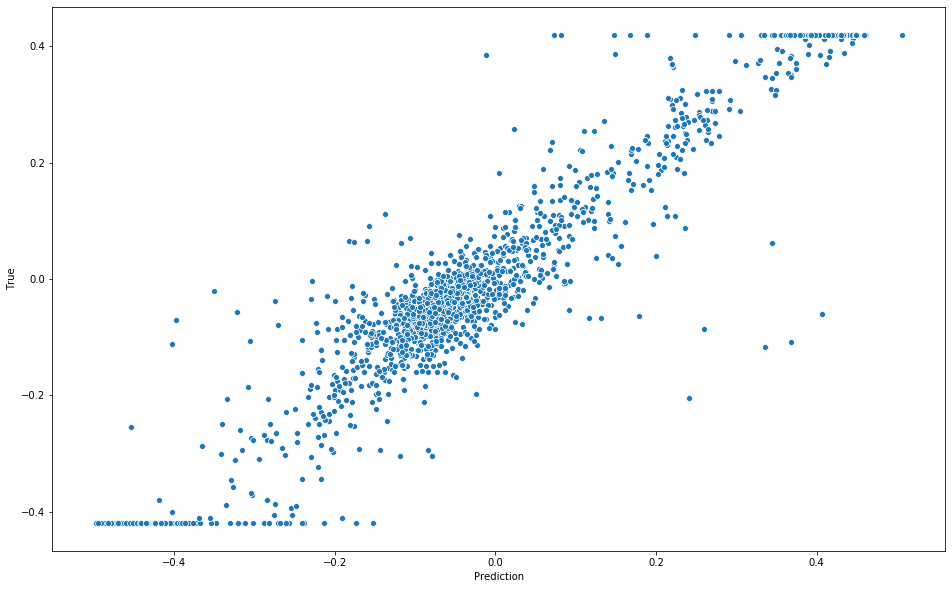

R2:  0.9389496467539782
MAE:  0.038189331695379955
MSE:  0.0034868810686173343


In [6]:
y_pred = mlp_best.predict(x_test)

results = pd.DataFrame()
results['Prediction'] = y_pred
results['True'] = y_test

fig = plt.figure(figsize=(16,10))
ax1 = fig.add_subplot(111)
cmap = sns.cubehelix_palette(dark=.3, light=.8, as_cmap=True)
ax1 = sns.scatterplot(x='Prediction', y='True', data=results, palette=cmap)
plt.show()
print("R2: ", r2_score(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("MSE: ", mean_squared_error(y_test, y_pred))

In [26]:
#Keras sequential model
inputs = Input(shape=(1081,))

dense1 = Dense(50)(inputs)
dense1 = Activation("relu")(dense1)

dense2 = Dense(70)(dense1)
dense2 = Activation("relu")(dense2)

dense3 = Dense(90)(dense2)
dense3 = Activation("relu")(dense3)

dense4 = Dense(90)(dense3)
dense4 = Activation("relu")(dense4)

dense5 = Dense(90)(dense4)
dense5 = Activation("relu")(dense5)


# softmax classifier
final = Dense(2)(dense5)
final = Activation("softmax")(final)

model = Model(inputs=inputs, outputs=final)
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1081)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                54100     
_________________________________________________________________
activation_9 (Activation)    (None, 50)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 51        
_________________________________________________________________
activation_10 (Activation)   (None, 1)                 0         
Total params: 54,151
Trainable params: 54,151
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer= Adam(), metrics=['accuracy'])

In [28]:
y_train_cat = keras.utils.to_categorical(y_train_res, 2)
y_test_cat = keras.utils.to_categorical(y_test, 2)

x_t, x_v, y_t, y_v = train_test_split(x_train_res, y_train_cat, test_size=0.20, random_state=42)

In [29]:
BATCH_SIZE = 24 
EPOCHS = 50

history = model.fit(x_t,y_t,
                    verbose=1,
                    epochs= EPOCHS,
                    validation_data=(x_v,y_v))

Train on 5648 samples, validate on 1413 samples
Epoch 1/50
5648/5648 [==============================] - 1s 170us/step - loss: 0.7848 - mean_squared_error: 0.7848 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 2/50
5648/5648 [==============================] - 1s 113us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 3/50
5648/5648 [==============================] - 1s 99us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 4/50
5648/5648 [==============================] - 1s 91us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 5/50
5648/5648 [==============================] - 1s 95us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 6/50
5648/5648 [==============================] - 1s 89us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 

Epoch 50/50
5648/5648 [==============================] - 0s 82us/step - loss: 0.0483 - mean_squared_error: 0.0483 - val_loss: 0.0506 - val_mean_squared_error: 0.0506


In [8]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Test loss: 0.052272238041931346
Test accuracy: 0.052272237837314606


In [ ]:
#fig, ax = plt.subplots(figsize=(16,10))
y_pred = clf.predict(x_test)
report = classification_report(y_test, y_pred)
plot_confusion_matrix(clf, x_test, y_test,
                        cmap=plt.cm.Blues,
                         normalize='true',
                         xticks_rotation='horizontal')
print(report)